In [28]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)
import os, shutil
from keras import models, layers, optimizers
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPool2D, Input, ZeroPadding2D, GlobalAveragePooling2D

import tensorflow_addons as tfa

In [27]:
# !pip install tensorflow_addons

     |████████████████████████████████| 613 kB 1.9 MB/s eta 0:00:01


## Our Evaluation Metrics:

We will look at Recall as our primary metric score and accuracy as our second score. The reason why we chose recall as our first evalulation metric score is due to lowering False Negatives which refers to when the patients are informed that the x-ray scan test showed that they do not have pneumonia when they do. This can cause fatal issues as pneumonia can lead to be life threatening. That is why we value Recall score. 
Also, we seek for a good accuracy score because we want to be able to be able to predict accurately on the positive cases which means pneumonia so that we are giving correct result to the patients who have tested positive for pneumonia.

## Creating Generators for train, test, and validation

In [2]:
# Directories:
train_directory = 'Data/chest_xray/train'
test_directory = 'Data/chest_xray/test'
val_directory = 'Data/chest_xray/val'

In [3]:
train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_directory,
                                                                          target_size = (256,256), 
                                                                          color_mode='grayscale',
                                                                          class_mode='binary')
test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_directory,
                                                                          target_size = (256,256), 
                                                                          color_mode='grayscale',
                                                                          class_mode='binary')
val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_directory,
                                                                          target_size = (256,256), 
                                                                          color_mode='grayscale',
                                                                          class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
# function for visualizing loss, accuracy, and recall across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

In [5]:
train_generator

# Baseline Model

Because there is such a big class imbalance, we can check to see how well a baseline model that only predicts the dominant, positive class performs.



In [6]:
'''def append_train(train_gen):
    X_train = []
    y_train = []
    for feature, label in train_gen:
        X_train.append(feature)
        y_train.append(label)
    return X_train, y_train

X_train, y_train = append_train(train_generator)'''

'def append_train(train_gen):\n    X_train = []\n    y_train = []\n    for feature, label in train_gen:\n        X_train.append(feature)\n        y_train.append(label)\n    return X_train, y_train\n\nX_train, y_train = append_train(train_generator)'

In [7]:
'''# create a baseline model that predicts the dominant class
def baseline_model(train, test):
    elements_unique, elements_counts  = np.unique(train, return_counts=True)
    count_dict={}
    for i in range(len(elements_unique)):
        count_dict.update({elements_counts[i]:elements_unique[i]})
    prediction = max(elements_counts)
    predicted = [count_dict[prediction] for i in range(len(test))]
    return predicted'''

'# create a baseline model that predicts the dominant class\ndef baseline_model(train, test):\n    elements_unique, elements_counts  = np.unique(train, return_counts=True)\n    count_dict={}\n    for i in range(len(elements_unique)):\n        count_dict.update({elements_counts[i]:elements_unique[i]})\n    prediction = max(elements_counts)\n    predicted = [count_dict[prediction] for i in range(len(test))]\n    return predicted'

In [8]:
# Check the accuracy and recall on the test set for our baseline model

#print('Test Accuracy:', accuracy_score(y_test, baseline_model(train_generator, test_generator)))
#print('Test Recall:', recall_score(y_test, baseline_model(train_generator, test_generator))

## CNN Model #1

In [9]:
# model fit
cnn_1 = models.Sequential()
cnn_1.add(layers.Conv2D(64, 3, activation = 'relu', input_shape=train_generator.image_shape))
cnn_1.add(layers.MaxPooling2D((2, 2)))
cnn_1.add(layers.Flatten())
cnn_1.add(layers.Dense(128, activation = 'relu'))
cnn_1.add(layers.Dense(1, activation='sigmoid'))
cnn_1.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'Recall'])


results_1 = cnn_1.fit(train_generator, 
                    epochs=50, 
                    validation_data = val_generator,
                    workers = 7, 
                    callbacks = [EarlyStopping(patience = 5, restore_best_weights=True)],
                    class_weight = {0: 3, 1: 1}
                   )

Epoch 1/50
163/163 [==============================] - 180s 1s/step - loss: 2.6720 - accuracy: 0.6415 - recall: 0.5649 - val_loss: 0.3937 - val_accuracy: 0.8750 - val_recall: 1.0000
Epoch 2/50
163/163 [==============================] - 181s 1s/step - loss: 0.2023 - accuracy: 0.9486 - recall: 0.9468 - val_loss: 0.1577 - val_accuracy: 0.9375 - val_recall: 1.0000
Epoch 3/50
163/163 [==============================] - 182s 1s/step - loss: 0.1538 - accuracy: 0.9576 - recall: 0.9566 - val_loss: 0.2685 - val_accuracy: 0.8750 - val_recall: 1.0000
Epoch 4/50
163/163 [==============================] - 184s 1s/step - loss: 0.1155 - accuracy: 0.9722 - recall: 0.9690 - val_loss: 0.1181 - val_accuracy: 0.9375 - val_recall: 1.0000
Epoch 5/50
163/163 [==============================] - 185s 1s/step - loss: 0.0756 - accuracy: 0.9803 - recall: 0.9786 - val_loss: 0.0669 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 6/50
163/163 [==============================] - 184s 1s/step - loss: 0.0538 - accuracy: 0

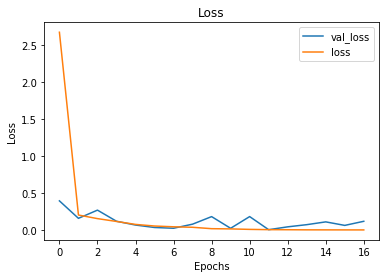

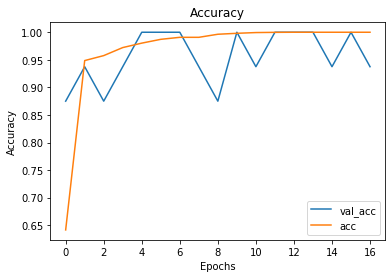

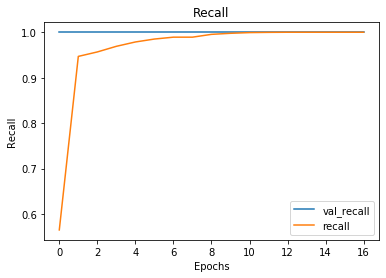

In [10]:
visualize_training_results(results_1)

We can see that as training loss starts rapidly converges to 0 after 1 epoche and validation loss is going up and down so we know this is overfitting model. So we will move on to the next model to try to address overfitting issues. 

In [11]:
cnn_1.evaluate(test_generator)

20/20 [==============================] - 8s 379ms/step - loss: 1.0263 - accuracy: 0.7997 - recall: 0.9872


[1.0262677669525146, 0.7996794581413269, 0.9871794581413269]

In terms of how our model has predicted on the test set seems pretty good in terms of recall but definitely need to increase accuracy rate. 

# CNN Model 2:

We will use CNN model except we will add additional inputs such as modifying learning rate in the optimizer because in our loss graph, we saw after epoch 1 the loss converges to 0 quickly. This showed us that after epoche of 1, model started overfitting. In this model, we will put few more layers to make the model a bit more complex and also increase epoches for the model to learn patterns about the data better.

In [12]:
train_generator.image_shape

(256, 256, 1)

In [13]:
cnn_2 = models.Sequential()
cnn_2.add(ZeroPadding2D(padding=(1, 1), input_shape=train_generator.image_shape))
cnn_2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Flatten())
cnn_2.add(layers.Dense(32, activation='relu'))
cnn_2.add(layers.Dense(1, activation='sigmoid'))

cnn_2.compile(loss='binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.01, amsgrad=True), 
              metrics=['accuracy', 'Recall'])
results_2 = cnn_2.fit(train_generator, 
                    epochs=15, 
                    validation_data = val_generator,
                    workers = -1, 
                    callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                    class_weight = {0: 3, 1: 1}
                   )

Epoch 1/15
163/163 [==============================] - 104s 640ms/step - loss: 1.1758 - accuracy: 0.7757 - recall: 0.7528 - val_loss: 0.5833 - val_accuracy: 0.5625 - val_recall: 0.6250
Epoch 2/15
163/163 [==============================] - 106s 649ms/step - loss: 0.5022 - accuracy: 0.8666 - recall: 0.8534 - val_loss: 0.5903 - val_accuracy: 0.6875 - val_recall: 1.0000
Epoch 3/15
163/163 [==============================] - 110s 673ms/step - loss: 0.4328 - accuracy: 0.8819 - recall: 0.8712 - val_loss: 0.3053 - val_accuracy: 0.8125 - val_recall: 1.0000
Epoch 4/15
163/163 [==============================] - 107s 659ms/step - loss: 0.2750 - accuracy: 0.9197 - recall: 0.9058 - val_loss: 0.1548 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 5/15
163/163 [==============================] - 102s 626ms/step - loss: 0.1913 - accuracy: 0.9473 - recall: 0.9417 - val_loss: 0.1591 - val_accuracy: 0.9375 - val_recall: 1.0000
Epoch 6/15
163/163 [==============================] - 103s 630ms/step - loss: 1.

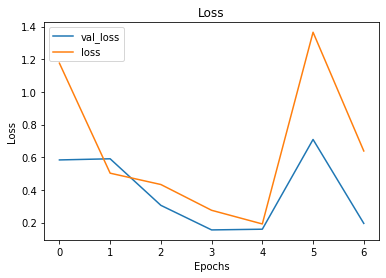

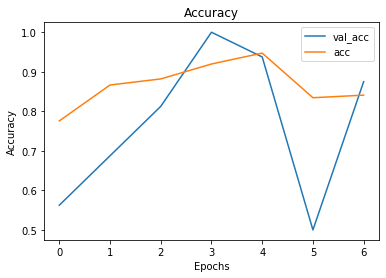

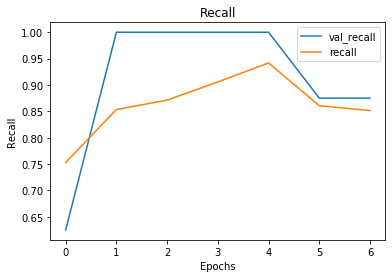

In [14]:
visualize_training_results(results_2)

My loss function started to converge to 0 and then spiked back up at 4th epoch. This could mean that there is bias in our model and might want to make the model more complex.

In [15]:
cnn_2.evaluate(test_generator)

20/20 [==============================] - 7s 330ms/step - loss: 0.7958 - accuracy: 0.7660 - recall: 0.9462


[0.7957602739334106, 0.7660256624221802, 0.9461538195610046]

Both recall and accuracy decreased from Model #1. This could be because I have made the model more complex by adding more layers.

# CNN Model 3:

Using different optimizer called AdamW with schedule learning rate and weight decay:

In [49]:
cnn_3 = models.Sequential()
cnn_3.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=train_generator.image_shape))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=train_generator.image_shape))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Flatten())
cnn_3.add(layers.Dense(32, activation='relu'))
cnn_3.add(layers.Dense(1, activation='sigmoid'))

# Tensorflow addons, AdamW
#schedule_lr = tf.optimizers.schedules.PiecewiseConstantDecay([1407*20, 1407*30], [1e-3, 1e-4, 1e-5])
#schedule_wd = tf.optimizers.schedules.PiecewiseConstantDecay([1407*20, 1407*30], [1e-4, 1e-5, 1e-6])
#optimizer = tfa.optimizers.AdamW(learning_rate=schedule_lr, weight_decay=schedule_wd, amsgrad=True)

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [1407*20, 1407*30], [1e-3, 1e-4, 1e-5])
wd = lambda: 1e-1 * schedule(step)

optimizer = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=wd, amsgrad=True)

cnn_3.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', 'Recall'])

results_3 = cnn_3.fit(train_generator,
                      epochs=30,
                      validation_data=val_generator,
                      callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                      class_weight = {0: 3, 1: 1},
                      workers = -1)

Epoch 1/30
163/163 [==============================] - 139s 851ms/step - loss: 0.2483 - accuracy: 0.8949 - recall: 0.9543 - val_loss: 0.3303 - val_accuracy: 0.7500 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 139s 852ms/step - loss: 0.0968 - accuracy: 0.9638 - recall: 0.9775 - val_loss: 0.3186 - val_accuracy: 0.7500 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 153s 937ms/step - loss: 0.0844 - accuracy: 0.9718 - recall: 0.9822 - val_loss: 0.1054 - val_accuracy: 0.9375 - val_recall: 0.8750
Epoch 4/30
163/163 [==============================] - 169s 1s/step - loss: 0.0710 - accuracy: 0.9751 - recall: 0.9840 - val_loss: 0.0720 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 5/30
163/163 [==============================] - 177s 1s/step - loss: 0.0557 - accuracy: 0.9787 - recall: 0.9853 - val_loss: 0.0916 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 6/30
163/163 [==============================] - 174s 1s/step - loss: 0.0447 - ac

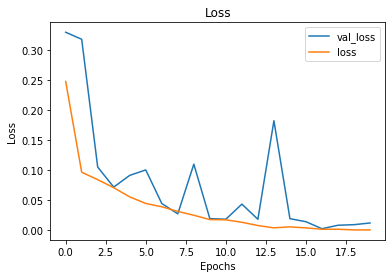

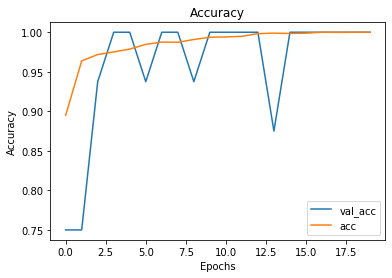

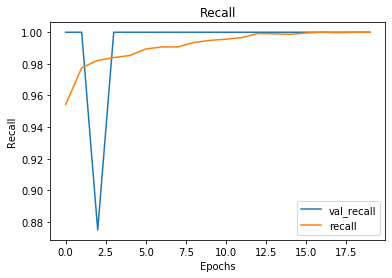

In [53]:
visualize_training_results(results_3)

In [54]:
cnn_3.evaluate(test_generator)

20/20 [==============================] - 5s 260ms/step - loss: 2.6307 - accuracy: 0.7580 - recall: 0.9923


[2.6306588649749756, 0.7580128312110901, 0.9923076629638672]

# CNN MODEL 4 w/ Data Augmentation + AdamW Optimizer

In [61]:
train_generator_aug = ImageDataGenerator(rescale = 1./255,
                                        rotation_range=25,
                                        zoom_range=0.25,
                                        brightness_range=[0.75, 1.25]).flow_from_directory(train_directory,
                                                                          target_size = (256,256), 
                                                                          color_mode='grayscale',
                                                                          class_mode='binary')


Found 5216 images belonging to 2 classes.


In [63]:
cnn_4 = models.Sequential()
cnn_4.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Flatten())
cnn_4.add(layers.Dense(32, activation='relu'))
cnn_4.add(layers.Dense(1, activation='sigmoid'))

cnn_4.compile(loss='binary_crossentropy',
              optimizer = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=wd, amsgrad=True),
              metrics=['accuracy', 'Recall'])
results_4 = cnn_4.fit(train_generator_aug,
                      epochs=30,
                      validation_data=val_generator,
                      callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                      class_weight = {0: 3, 1: 1},
                      workers = -1)

Epoch 1/30
163/163 [==============================] - 160s 981ms/step - loss: 0.6377 - accuracy: 0.7945 - recall: 0.7837 - val_loss: 0.5642 - val_accuracy: 0.8125 - val_recall: 0.7500
Epoch 2/30
163/163 [==============================] - 160s 979ms/step - loss: 0.4537 - accuracy: 0.8692 - recall: 0.8625 - val_loss: 0.5382 - val_accuracy: 0.7500 - val_recall: 0.6250
Epoch 3/30
163/163 [==============================] - 160s 981ms/step - loss: 0.4011 - accuracy: 0.8903 - recall: 0.8797 - val_loss: 0.5906 - val_accuracy: 0.5625 - val_recall: 0.8750
Epoch 4/30
163/163 [==============================] - 160s 982ms/step - loss: 0.3869 - accuracy: 0.8911 - recall: 0.8836 - val_loss: 0.4010 - val_accuracy: 0.8125 - val_recall: 0.7500
Epoch 5/30
163/163 [==============================] - 161s 988ms/step - loss: 0.3715 - accuracy: 0.8997 - recall: 0.8908 - val_loss: 0.6371 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 6/30
163/163 [==============================] - 163s 999ms/step - loss: 0.

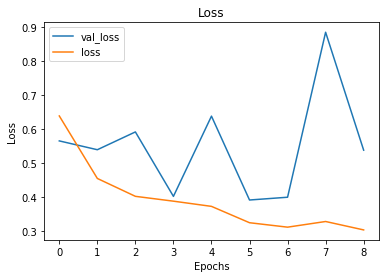

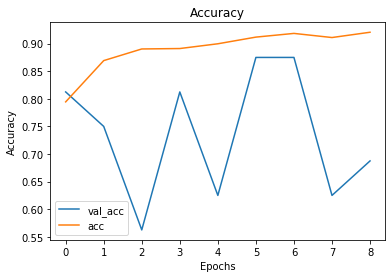

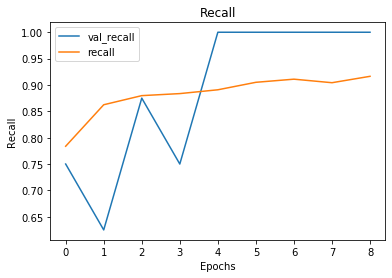

In [64]:
visualize_training_results(results_4)

In [65]:
cnn_4.evaluate(test_generator)

20/20 [==============================] - 6s 289ms/step - loss: 0.2492 - accuracy: 0.9119 - recall: 0.9333


[0.24918785691261292, 0.9118589758872986, 0.9333333373069763]

# CNN MODEL 5 w/ Data Augmentation

We will reinstantiate to add data augmentation such as rotation, brightness, zoom, scale and etc

In [50]:
train_generator_aug = ImageDataGenerator(rescale = 1./255,
                                        rotation_range=25,
                                        zoom_range=0.25,
                                        brightness_range=[0.75, 1.25]).flow_from_directory(train_directory,
                                                                          target_size = (256,256), 
                                                                          color_mode='grayscale',
                                                                          class_mode='binary')


Found 5216 images belonging to 2 classes.


In [51]:
train_generator_aug.image_shape

(256, 256, 1)

In [58]:
cnn_5 = models.Sequential()
cnn_5.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_5.add(layers.MaxPooling2D((2, 2)))
cnn_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_5.add(layers.MaxPooling2D((2, 2)))
cnn_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_5.add(layers.MaxPooling2D((2, 2)))
cnn_5.add(layers.Flatten())
cnn_5.add(layers.Dense(32, activation='relu'))
cnn_5.add(layers.Dense(1, activation='sigmoid'))

cnn_5.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])
results_5 = cnn_5.fit(train_generator_aug,
                      epochs=30,
                      validation_data=val_generator,
                      callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                      class_weight = {0: 3, 1: 1},
                      workers = -1)

Epoch 1/30
163/163 [==============================] - 158s 970ms/step - loss: 0.5690 - accuracy: 0.8186 - recall: 0.7990 - val_loss: 0.6096 - val_accuracy: 0.6250 - val_recall: 0.8750
Epoch 2/30
163/163 [==============================] - 158s 971ms/step - loss: 0.4386 - accuracy: 0.8829 - recall: 0.8795 - val_loss: 0.3684 - val_accuracy: 0.8750 - val_recall: 0.8750
Epoch 3/30
163/163 [==============================] - 157s 966ms/step - loss: 0.3958 - accuracy: 0.8967 - recall: 0.8919 - val_loss: 0.4024 - val_accuracy: 0.7500 - val_recall: 0.6250
Epoch 4/30
163/163 [==============================] - 157s 963ms/step - loss: 0.3515 - accuracy: 0.9114 - recall: 0.9053 - val_loss: 0.5182 - val_accuracy: 0.7500 - val_recall: 1.0000
Epoch 5/30
163/163 [==============================] - 162s 993ms/step - loss: 0.3378 - accuracy: 0.9116 - recall: 0.9061 - val_loss: 0.5881 - val_accuracy: 0.7500 - val_recall: 1.0000


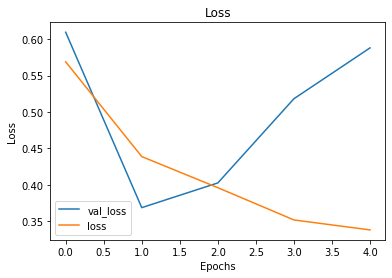

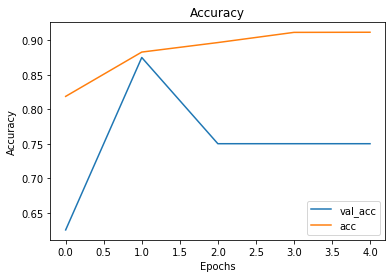

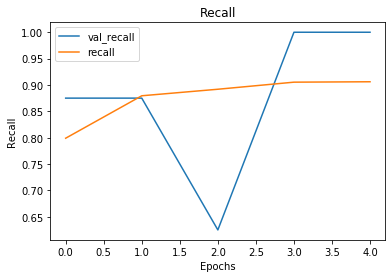

In [59]:
visualize_training_results(results_5)

In [60]:
cnn_5.evaluate(test_generator)

20/20 [==============================] - 5s 249ms/step - loss: 0.3674 - accuracy: 0.8413 - recall: 0.7949


[0.3673652708530426, 0.8413461446762085, 0.7948718070983887]

In [ ]:
# CNN MODEL 6 w/ Data Augmentation

In [84]:
cnn_6 = models.Sequential()
cnn_6.add(layers.ZeroPadding2D((1,1), input_shape=train_generator_aug.image_shape))
cnn_6.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_6.add(layers.MaxPooling2D((2, 2)))
cnn_6.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_6.add(layers.MaxPooling2D((2, 2)))
cnn_6.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_6.add(layers.MaxPooling2D((2, 2)))

cnn_6.add(layers.Flatten())
cnn_6.add(layers.Dense(32, activation='relu'))
cnn_6.add(layers.Dense(4096, activation='relu'))
cnn_6.add(layers.Dropout(0.5))
cnn_6.add(layers.Dense(4096, activation='relu'))
cnn_6.add(layers.Dropout(0.5))
cnn_6.add(layers.Dense(1, activation='sigmoid'))

cnn_6.compile(loss='binary_crossentropy',
              optimizer = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=wd, amsgrad=True),
              metrics=['accuracy', 'Recall'])
results_6 = cnn_6.fit(train_generator_aug,
                      epochs=30,
                      validation_data=val_generator,
                      callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                      class_weight = {0: 3, 1: 1},
                      workers = -1)

Epoch 1/30
163/163 [==============================] - 293s 2s/step - loss: 0.7097 - accuracy: 0.7341 - recall: 0.6952 - val_loss: 0.4162 - val_accuracy: 0.7500 - val_recall: 0.7500
Epoch 2/30
163/163 [==============================] - 293s 2s/step - loss: 0.4614 - accuracy: 0.8637 - recall: 0.8465 - val_loss: 0.4858 - val_accuracy: 0.8750 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 282s 2s/step - loss: 0.4297 - accuracy: 0.8863 - recall: 0.8712 - val_loss: 0.2775 - val_accuracy: 0.8750 - val_recall: 0.8750
Epoch 4/30
163/163 [==============================] - 296s 2s/step - loss: 0.4836 - accuracy: 0.8650 - recall: 0.8542 - val_loss: 0.9343 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 5/30
163/163 [==============================] - 292s 2s/step - loss: 0.3690 - accuracy: 0.9018 - recall: 0.8903 - val_loss: 0.9942 - val_accuracy: 0.6875 - val_recall: 1.0000
Epoch 6/30
163/163 [==============================] - 290s 2s/step - loss: 0.3848 - accuracy: 0

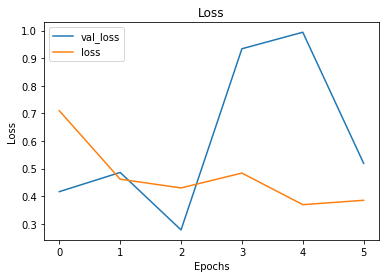

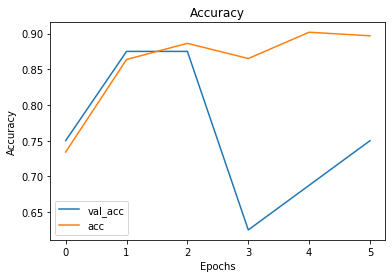

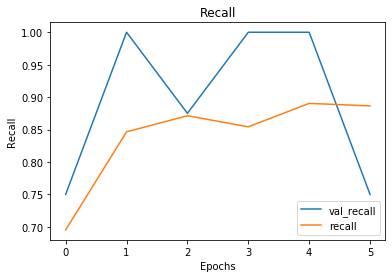

In [85]:
visualize_training_results(results_6)

In [86]:
cnn_6.evaluate(test_generator)

20/20 [==============================] - 7s 338ms/step - loss: 0.3556 - accuracy: 0.8542 - recall: 0.8256


[0.355560302734375, 0.8541666865348816, 0.8256410360336304]

In [ ]:
# MODEL 7 with ADAGRAD

In [92]:
cnn_7 = models.Sequential()
cnn_7.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_7.add(layers.MaxPooling2D((2, 2)))
cnn_7.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_7.add(layers.MaxPooling2D((2, 2)))
cnn_7.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=train_generator_aug.image_shape))
cnn_7.add(layers.MaxPooling2D((2, 2)))
cnn_7.add(layers.Flatten())
cnn_7.add(layers.Dense(32, activation='relu'))
cnn_7.add(layers.Dense(1, activation='sigmoid'))

cnn_7.compile(loss='binary_crossentropy',
              optimizer = optimizers.Adagrad(learning_rate=0.001),
              metrics=['accuracy', 'Recall'])
results_7 = cnn_7.fit(train_generator_aug,
                      epochs=30,
                      validation_data=val_generator,
                      callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                      class_weight = {0: 3, 1: 1},
                      workers = -1)

Epoch 1/30
163/163 [==============================] - 156s 956ms/step - loss: 1.0389 - accuracy: 0.4829 - recall: 0.3701 - val_loss: 0.6782 - val_accuracy: 0.5625 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 154s 942ms/step - loss: 0.9914 - accuracy: 0.6693 - recall: 0.6545 - val_loss: 0.6546 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 3/30
163/163 [==============================] - 155s 948ms/step - loss: 0.8569 - accuracy: 0.7207 - recall: 0.7027 - val_loss: 0.5946 - val_accuracy: 0.6875 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 160s 981ms/step - loss: 0.7425 - accuracy: 0.7609 - recall: 0.7597 - val_loss: 0.6243 - val_accuracy: 0.6875 - val_recall: 1.0000
Epoch 5/30
163/163 [==============================] - 163s 999ms/step - loss: 0.6587 - accuracy: 0.8060 - recall: 0.8039 - val_loss: 0.6177 - val_accuracy: 0.6250 - val_recall: 0.5000
Epoch 6/30
163/163 [==============================] - 158s 970ms/step - loss

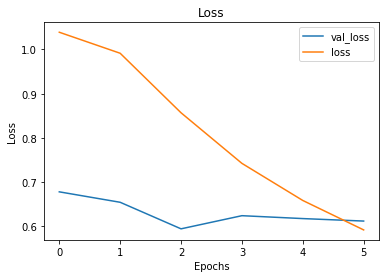

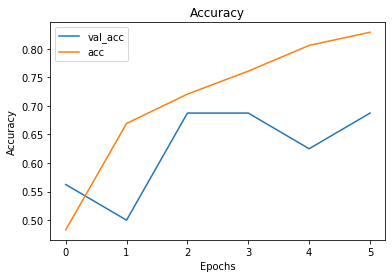

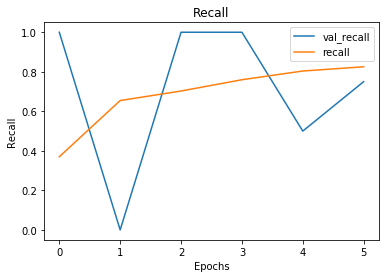

In [93]:
visualize_training_results(results_7)

In [94]:
cnn_7.evaluate(test_generator)

20/20 [==============================] - 5s 249ms/step - loss: 0.4659 - accuracy: 0.8141 - recall: 0.8462


[0.4659222960472107, 0.8141025900840759, 0.8461538553237915]

In [95]:
# Mode 8:

In [102]:
cnn_8 = models.Sequential()
cnn_8.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=train_generator_aug.image_shape))
cnn_8.add(layers.MaxPooling2D((2, 2)))
cnn_8.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=train_generator_aug.image_shape))
cnn_8.add(layers.MaxPooling2D((2, 2)))
cnn_8.add(layers.Conv2D(364, (3, 3), activation='relu', padding = 'same', input_shape=train_generator_aug.image_shape))
cnn_8.add(layers.MaxPooling2D((2, 2)))
cnn_8.add(layers.Flatten())
cnn_8.add(layers.Dense(256, activation='relu'))
cnn_8.add(layers.Dense(1, activation='sigmoid'))


cnn_8.compile(loss='binary_crossentropy',
              optimizer=tfa.optimizers.AdamW(amsgrad = True, learning_rate=schedule, weight_decay=wd),
              metrics=['accuracy', 'Recall'])
results_8 = cnn_8.fit(train_generator_aug,
                      epochs = 20,
                      validation_data=val_generator,
                      class_weight = {0: 3, 1: 1})

Epoch 1/20
163/163 [==============================] - 357s 2s/step - loss: 0.7331 - accuracy: 0.7995 - recall: 0.7876 - val_loss: 0.6689 - val_accuracy: 0.6250 - val_recall: 0.8750
Epoch 2/20
163/163 [==============================] - 389s 2s/step - loss: 0.4824 - accuracy: 0.8629 - recall: 0.8539 - val_loss: 0.4397 - val_accuracy: 0.8750 - val_recall: 0.8750
Epoch 3/20
163/163 [==============================] - 430s 3s/step - loss: 0.4046 - accuracy: 0.8913 - recall: 0.8831 - val_loss: 0.4135 - val_accuracy: 0.8125 - val_recall: 0.8750
Epoch 4/20
163/163 [==============================] - 442s 3s/step - loss: 0.3823 - accuracy: 0.8901 - recall: 0.8787 - val_loss: 0.5076 - val_accuracy: 0.8125 - val_recall: 0.8750
Epoch 5/20
163/163 [==============================] - 422s 3s/step - loss: 0.3585 - accuracy: 0.8984 - recall: 0.8880 - val_loss: 0.3586 - val_accuracy: 0.8125 - val_recall: 0.8750
Epoch 6/20
163/163 [==============================] - 406s 2s/step - loss: 0.3240 - accuracy: 0

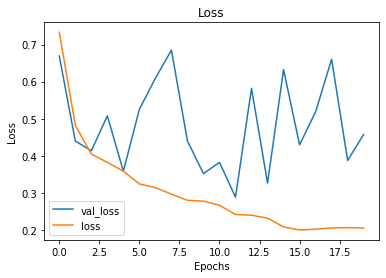

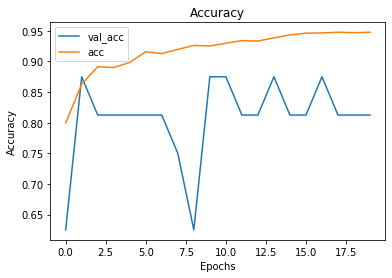

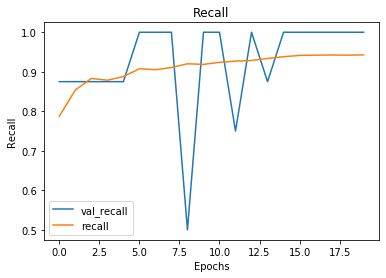

In [103]:
visualize_training_results(results_8)

In [104]:
cnn_8.evaluate(test_generator)

20/20 [==============================] - 14s 711ms/step - loss: 0.2869 - accuracy: 0.9119 - recall: 0.9538


[0.28687915205955505, 0.9118589758872986, 0.9538461565971375]